In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

# Create a new function, "fast_subsystem" with eps=0 based on fast_system
fast_subsystem = partial(fast_system, eps=0)

# Define the Jacobian function
def jacobian(func, y):
    n = len(y)
    J = np.zeros((n, n))
    for i in range(n):
        epsilon = 1e-6  # Small perturbation
        y_perturbed = np.array(y.copy(), dtype=float)  
        y_perturbed[i] += epsilon
        dy = np.array(func(y_perturbed, 0)) - np.array(func(y, 0))
        J[:, i] = dy / epsilon
    return J

# Find equilibrium points of fast_subsystem numerically
equilibrium_points = [np.zeros(len(fast_system([0, 0, 0], 0, 0)))] # [np.zeros(len(y))]

# Compute Jacobian matrix at each equilibrium point
for eq_point in equilibrium_points:
    J_eq = jacobian(fast_subsystem, eq_point)
    eigenvalues, eigenvectors = np.linalg.eig(J_eq)
    print("Jacobian Matrix:")
    print(J_eq)
    print("Eigenvalues:")
    print(eigenvalues)
    print("Eigenvectors:")
    print(eigenvectors)
    print()
    # Check if any eigenvalue has a pure imaginary part
    if any(np.imag(eigenvalues) != 0):
        print("The system is NOT NORMALLY HYPERBOLIC. Stopping...")
        break
    else:
        print("The system is NORMALLY HYPERBOLIC. Proceeding...\n")

def slow_system(y, tau, eps):
    x, y, z = y
    dxdtau = -x/eps
    dydtau = (2 * y + eps * x)/eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

def slow_subsystem(y, tau):
    x, y, z = y
    dxdtau = 0
    dydtau = 0
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]


# Initial points x, y, z:
x_init, y_init, z_init = 1.0, 0.0, 0.0
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}, z_init = {z_init}")

t_end = 100
t  =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0, -t_end, 100)
eps = 0.01
T_slow_end = 1
tau = np.linspace(0, T_slow_end, 100)


x_end, y_end, z_end = 0.0, 1.0, 1.0
   
#xf_end, yf_end, zf_end = 1.5, 0.4, 0.9    
#xf2_end, yf2_end, zf2_end = 1.0, 1.0, 1.0
#xs_init, ys_init, zs_init = 1.0, 1.0, 1.0
#xs_end, ys_end, zs_end = 1.0, 1.0, 1.0
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}, z_end = {z_end}")

t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 100

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

def total_loss_func(model_fast, model_fast2, model_slow,\
                    t_tensor, t2_tensor, tau_tensor,\
                    x_init, y_init, z_init, x_end, y_end, z_end,\
                    eps, phys_weight=100.0, weight_fast=1.0, weight_slow=1.0 ):
    t_tensor.requires_grad = True
    t2_tensor.requires_grad = True
    tau_tensor.requires_grad = True

    pred_fast = model_fast(t_tensor)
    pred_fast2 = model_fast2(t2_tensor)
    pred_slow = model_slow(tau_tensor)


    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1), pred_fast[:, 2].unsqueeze(1)
    x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1), pred_fast2[:, 2].unsqueeze(1)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)

    try:
        xf_end, yf_end, zf_end = float(x_pred_slow[0]), float(y_pred_slow[0]), float(z_pred_slow[0])
    except (TypeError, IndexError, NameError):
        xf_end, yf_end, zf_end = 0.0, 0.0, 0.0
    
    # Calculate derivatives
    ones_fast = torch.ones_like(x_pred_fast, requires_grad=True)
    dx_dt_fast = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones_fast, retain_graph=True, create_graph=True)[0]
    dy_dt_fast = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones_fast, retain_graph=True, create_graph=True)[0]
    dz_dt_fast = torch.autograd.grad(z_pred_fast, t_tensor, grad_outputs=ones_fast, retain_graph=True, create_graph=True)[0]
    
    ones_fast2 = torch.ones_like(x_pred_fast2, requires_grad=True)
    dx_dt_fast2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones_fast2, retain_graph=True, create_graph=True)[0]
    dy_dt_fast2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones_fast2, retain_graph=True, create_graph=True)[0]
    dz_dt_fast2 = torch.autograd.grad(z_pred_fast2, t2_tensor, grad_outputs=ones_fast2, retain_graph=True, create_graph=True)[0]
    
    ones_slow = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau_slow = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones_slow, retain_graph=True, create_graph=True)[0]
    dy_dtau_slow = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones_slow, retain_graph=True, create_graph=True)[0]
    dz_dtau_slow = torch.autograd.grad(z_pred_slow, tau_tensor, grad_outputs=ones_slow, retain_graph=True, create_graph=True)[0]

    # Calculate residuals and losses
    residual1_fast = dx_dt_fast + x_pred_fast
    residual2_fast = dy_dt_fast - 2 * y_pred_fast
    residual3_fast = dz_dt_fast
    residual4_fast = dy_dt_fast - 2 * y_pred_fast - eps * x_pred_fast
    residual5_fast = dz_dt_fast - eps * (x_pred_fast**2 + 1)
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init) +\
                     torch.square(z_pred_fast[0] - z_init)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2)
    #boundary_loss_fast = torch.square(x_pred_fast[-1] - xf_end) +\
    #                     torch.square(y_pred_fast[-1] - yf_end) +\
    #                     torch.square(z_pred_fast[-1] - zf_end)

    #try:
    #    xf2_end, yf2_end, zf2_end = x_pred_slow[-1], y_pred_slow[-1], z_pred_slow[-1]
    #except (TypeError, IndexError, NameError ):
     #    xf2_end, yf2_end, zf2_end = 0.0, 0.0, 0.0
         
    residual1_fast2 = dx_dt_fast2 + x_pred_fast2
    residual2_fast2 = dy_dt_fast2 - 2 * y_pred_fast2
    residual3_fast2 = dz_dt_fast2
    residual4_fast2 = dy_dt_fast2 - 2 * y_pred_fast2 - eps * x_pred_fast2
    residual5_fast2 = dz_dt_fast2 - eps * (x_pred_fast2**2 + 1)
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) +\
                      torch.square(z_pred_fast2[0] - z_end)
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2 + residual4_fast2**2 +\
                                    residual5_fast2**2)
    #boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - xf2_end) +\
    #                      torch.square(y_pred_fast2[-1] - yf2_end) +\
    #                      torch.square(z_pred_fast2[-1] - zf2_end)

    residual1_slow = dx_dtau_slow
    residual2_slow = dy_dtau_slow
    residual3_slow = dz_dtau_slow - x_pred_slow**2 - 1
    init_loss_slow = torch.square(x_pred_slow[0] - x_pred_fast[-1]) +\
                     torch.square(y_pred_slow[0] - y_pred_fast[-1]) +\
                     torch.square(z_pred_slow[0] - z_pred_fast[-1])
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 +\
                                   residual3_slow**2)
    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_pred_fast2[-1]) +\
                         torch.square(y_pred_slow[-1] - y_pred_fast2[-1]) +\
                         torch.square(z_pred_slow[-1] - z_pred_fast2[-1])

    loss_fast = phys_weight * physics_loss_fast +\
                                 init_loss_fast #+
    #                         boundary_loss_fast
    
    loss_fast2 = phys_weight * physics_loss_fast2 +\
                                  init_loss_fast2 #+\
    #                          boundary_loss_fast2
    
    loss_slow = phys_weight * physics_loss_slow +\
                                 init_loss_slow +\
                             boundary_loss_slow 
                        
    
    total_loss = weight_fast * loss_fast  +\
                 weight_fast * loss_fast2 +\
                 weight_slow * loss_slow 
                 
    if epoch % 1000 == 0:
        print('xf_end, yf_end, zf_end are:', f"xf_end = {xf_end}, yf_end = {yf_end}, zf_end = {zf_end}")
            
    
    return total_loss





Jacobian Matrix:
[[-1.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  0.]]
Eigenvalues:
[-1.  2.  0.]
Eigenvectors:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

The system is NORMALLY HYPERBOLIC. Proceeding...

The initial points of the BVP: x_init = 1.0, y_init = 0.0, z_init = 0.0
The ending points of the BVP: x_end = 0.0, y_end = 1.0, z_end = 1.0


xf_end, yf_end, zf_end are: xf_end = 0.012133269081947506, yf_end = -0.2994655866634302, zf_end = -0.08150053375886437
Epoch 0, Total Loss: 190.21538868405645
xf_end, yf_end, zf_end are: xf_end = 0.004924239146903493, yf_end = 0.0010007223502749886, zf_end = 85.69489035509052
Epoch 1000, Total Loss: 4.396006779403768
xf_end, yf_end, zf_end are: xf_end = 0.0018756782344038353, yf_end = 0.005963399614919998, zf_end = 99.92843681944801
Epoch 2000, Total Loss: 1.0178794243091995
xf_end, yf_end, zf_end are: xf_end = 0.0008900303818040883, yf_end = 0.0017435431257005925, zf_end = 100.8385609117831
Epoch 3000, Total Loss: 0.9711509250966299
xf_end, yf_end, zf_end are: xf_end = 0.0008932532509230845, yf_end = -0.004231505890906311, zf_end = 100.86301313492625
Epoch 4000, Total Loss: 1.5372702685321975
xf_end, yf_end, zf_end are: xf_end = -0.0019902086562290366, yf_end = 0.009038032346684603, zf_end = 100.76767077893308
Epoch 5000, Total Loss: 0.875070180881429
xf_end, yf_end, zf_end are: xf_en

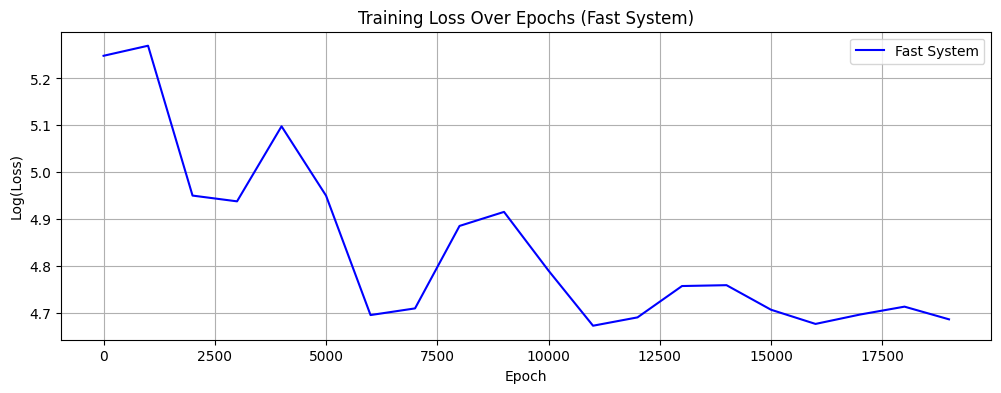

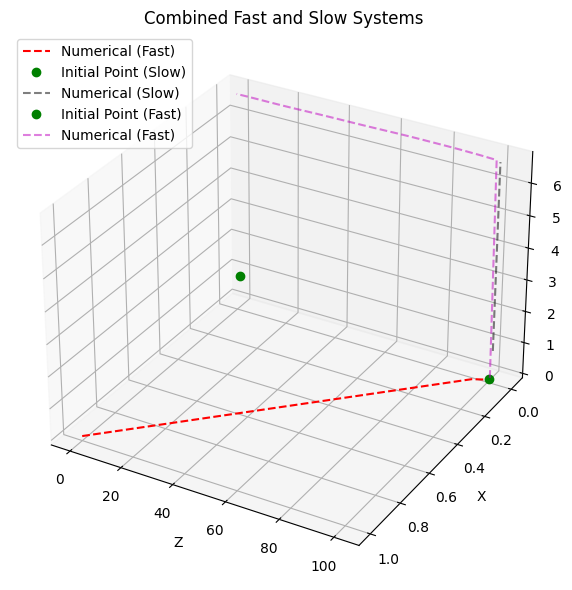

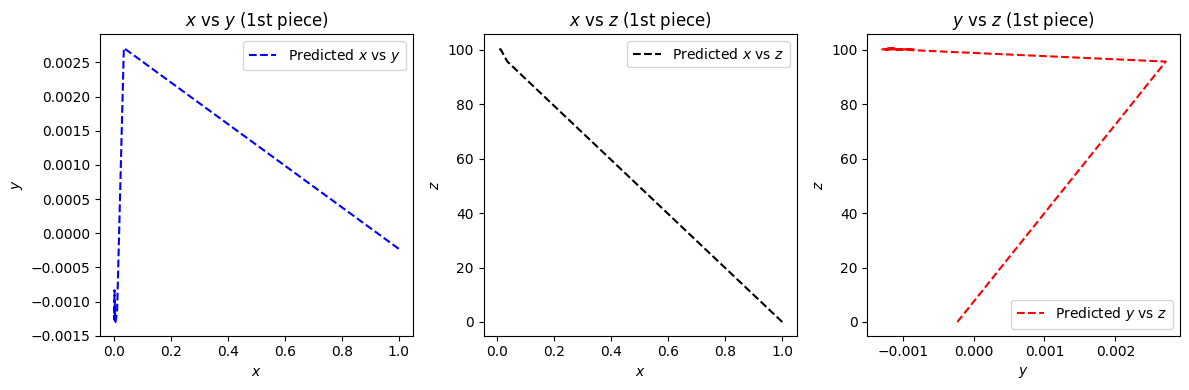

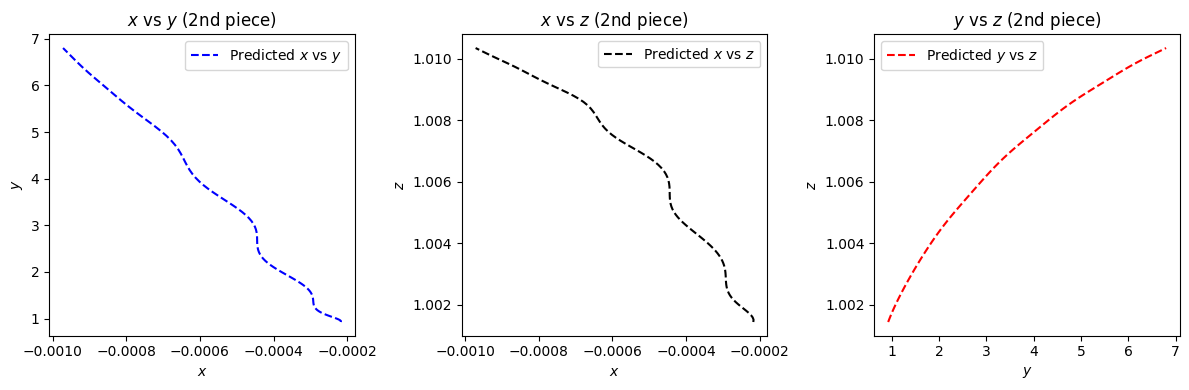

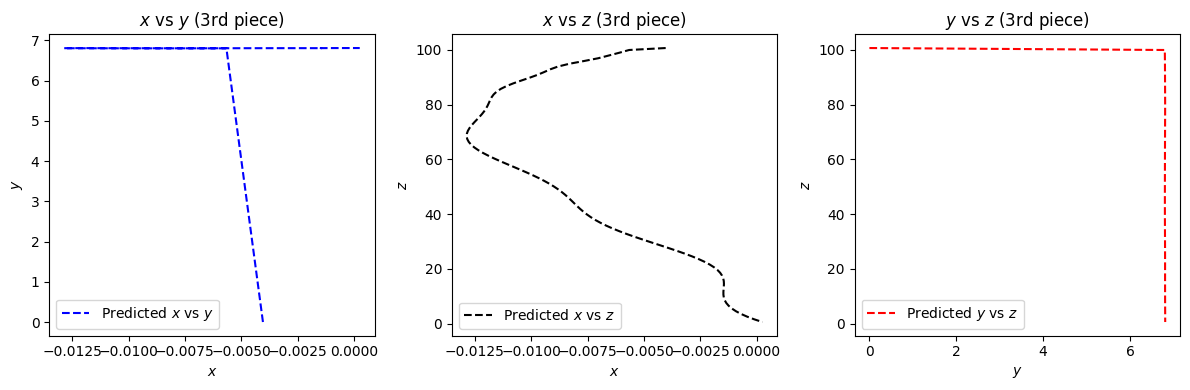

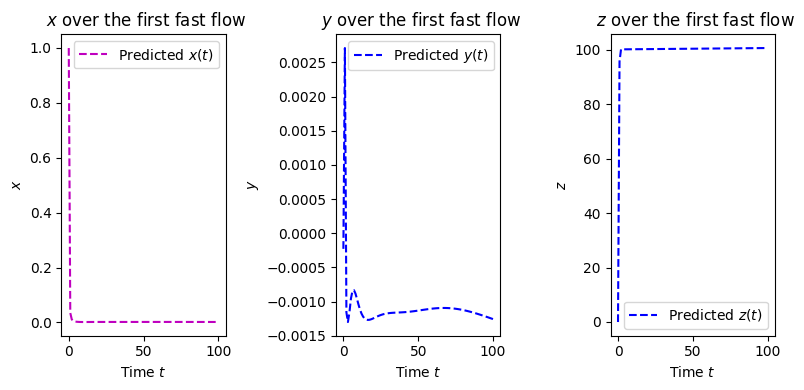

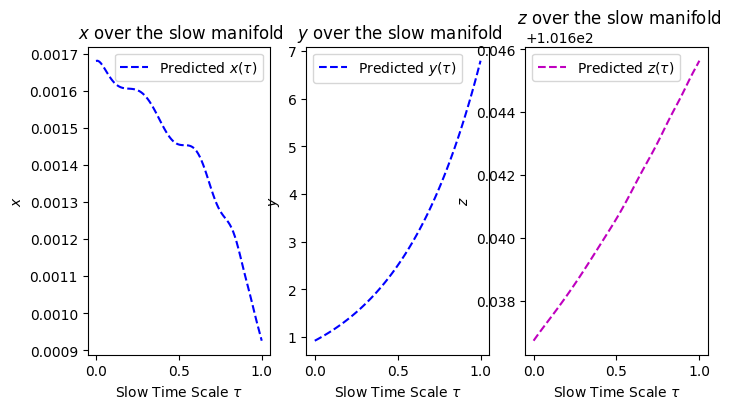

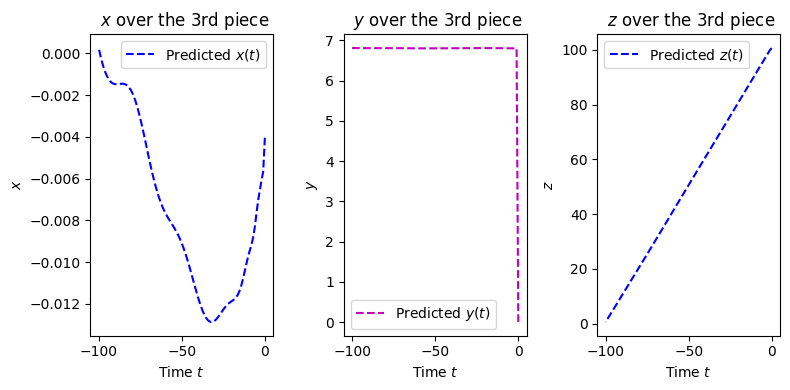

In [2]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 20000


    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                     t_tensor, tau_tensor, t2_tensor,\
                                     x_init, y_init, z_init,\
                                     x_end, y_end, z_end, eps,\
                                     phys_weight=100.0, weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        #x1, y1, z1 = x_pred_slow[0], y_pred_slow[0], z_pred_slow[0]
        
        #x2, y2, z2 = x_pred_slow[-1], y_pred_slow[-1], z_pred_slow[-1]
        #xf2_end, yf2_end, zf2_end = x_pred_fast2[-1], y_pred_fast2[-1], z_pred_fast2[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
            
            #print('xf_end, yf_end, zf_end are:', f"xf_end = {xf_end}, yf_end = {yf_end}, zf_end = {zf_end}")
            #print('xf2_end, yf2_end, zf2_end are:', f"xf2_end = {xf2_end}, yf2_end = {yf2_end}, zf2_end = {zf2_end}")

        loss_values.append(loss_total.item())
        
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_fast2.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
        # Predictions for fast system
        x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
    # Plotting the 3D trajectories
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting fast system
    #ax.plot(z_exact_fast, x_exact_fast, y_exact_fast, 'b-', label='Exact (Fast)')
    ax.plot(z_pred_fast, x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

    # Plotting slow system initial point
    ax.plot(z_pred_fast[-1], x_pred_fast[-1], y_pred_fast[-1], 'go', label='Initial Point (Slow)')

    # Plotting slow system continuation
    #ax.plot(z_exact_slow + z1, x_exact_slow + x1, y_exact_slow + y1, 'g-', label='Exact (Slow)', alpha=0.5)
    ax.plot(z_pred_slow + z_pred_fast[-1],\
            x_pred_slow + x_pred_fast[-1],\
            y_pred_slow + y_pred_fast[-1], 'k--', label='Numerical (Slow)', alpha=0.5)

    # Plotting slow system initial point
    ax.plot(z_end, x_end, y_end, 'go', label='Initial Point (Fast)')

    # Plotting fast system continuation
    #ax.plot(z_exact_fast2  , x_exact_fast2  , y_exact_fast2 , 'm-', label='Exact (Fast)', alpha=0.5)
    ax.plot(z_pred_fast2  , x_pred_fast2 , y_pred_fast2 , 'm--', label='Numerical (Fast)', alpha=0.5)

    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    ax.set_title('Combined Fast and Slow Systems')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    
    

    
    # Plotting "x" vs "y", "x" vs "z", and "y" vs "z": over the 1st piece
    plt.figure(figsize=(12, 4))

    # "x" vs "y"
    plt.subplot(1, 3, 1)
    plt.plot(x_pred_fast, y_pred_fast, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (1st piece)')
    plt.legend()

    # "x" vs "z"
    plt.subplot(1, 3, 2)
    plt.plot(x_pred_fast, z_pred_fast, 'k--', label='Predicted $x$ vs $z$')
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.title('$x$ vs $z$ (1st piece)')
    plt.legend()

    # "y" vs "z"
    plt.subplot(1, 3, 3)
    plt.plot(y_pred_fast, z_pred_fast, 'r--', label='Predicted $y$ vs $z$')
    plt.xlabel('$y$')
    plt.ylabel('$z$')
    plt.title('$y$ vs $z$ (1st piece)')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Plotting "x" vs "y", "x" vs "z", and "y" vs "z": over the 2nd piece
    plt.figure(figsize=(12, 4))

    # "x" vs "y"
    plt.subplot(1, 3, 1)
    plt.plot(x_pred_slow, y_pred_slow, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (2nd piece)')
    plt.legend()

    # "x" vs "z"
    plt.subplot(1, 3, 2)
    plt.plot(x_pred_slow, z_pred_slow, 'k--', label='Predicted $x$ vs $z$')
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.title('$x$ vs $z$ (2nd piece)')
    plt.legend()

    # "y" vs "z"
    plt.subplot(1, 3, 3)
    plt.plot(y_pred_slow, z_pred_slow, 'r--', label='Predicted $y$ vs $z$')
    plt.xlabel('$y$')
    plt.ylabel('$z$')
    plt.title('$y$ vs $z$ (2nd piece)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotting "x" vs "y", "x" vs "z", and "y" vs "z": over the 3rd piece
    plt.figure(figsize=(12, 4))

    # "x" vs "y"
    plt.subplot(1, 3, 1)
    plt.plot(x_pred_fast2, y_pred_fast2, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('$x$ vs $y$ (3rd piece)')
    plt.legend()

    # "x" vs "z"
    plt.subplot(1, 3, 2)
    plt.plot(x_pred_fast2, z_pred_fast2, 'k--', label='Predicted $x$ vs $z$')
    plt.xlabel('$x$')
    plt.ylabel('$z$')
    plt.title('$x$ vs $z$ (3rd piece)')
    plt.legend()

    # "y" vs "z"
    plt.subplot(1, 3, 3)
    plt.plot(y_pred_fast2, z_pred_fast2, 'r--', label='Predicted $y$ vs $z$')
    plt.xlabel('$y$')
    plt.ylabel('$z$')
    plt.title('$y$ vs $z$ (3rd piece)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
     #########1st piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    #plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
    plt.plot(t, x_pred_fast, 'm--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the first fast flow')
    plt.legend()

    plt.subplot(1, 3, 2)
    #plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
    plt.plot(t, y_pred_fast, 'b--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the first fast flow')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    #plt.plot(t, z_exact_fast, 'b-', label='Exact $y(t)$')
    plt.plot(t, z_pred_fast, 'b--', label='Predicted $z(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$z$')
    plt.title(' $z$ over the first fast flow')
    plt.legend()
    

    plt.tight_layout()
    plt.show()
    
    ########2nd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    #plt.plot(tau, x_exact_slow + x_exact_fast[-1], 'b-', label='Exact $x(t)$')
    plt.plot(tau, x_pred_slow + x_pred_fast[-1], 'b--', label='Predicted $x(\\tau)$')
    plt.xlabel('Slow Time Scale $\\tau$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the slow manifold')
    plt.legend()

    plt.subplot(1, 3, 2)
    #plt.plot(tau, y_exact_slow + y_exact_fast[-1], 'b-', label='Exact $y(t)$')
    plt.plot(tau, y_pred_slow + y_pred_fast[-1], 'b--', label='Predicted $y(\\tau)$')
    plt.xlabel('Slow Time Scale $\\tau$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the slow manifold')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    #plt.plot(tau, z_exact_slow + z_exact_fast[-1], 'g-', label='Exact $z(\\tau)$')
    plt.plot(tau, z_pred_slow + z_pred_fast[-1], 'm--', label='Predicted $z(\\tau)$')
    plt.xlabel('Slow Time Scale $\\tau$')
    plt.ylabel('$z$')
    plt.title(' $z$ over the slow manifold')
    plt.legend()
    
    ########3rd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    #plt.plot(t2, x_exact_fast2 , 'b-', label='Exact $x(t)$')
    plt.plot(t2, x_pred_fast2 , 'b--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the 3rd piece')
    plt.legend()

    plt.subplot(1, 3, 2)
    #plt.plot(t2, y_exact_fast2 , 'b-', label='Exact $y(t)$')
    plt.plot(t2, y_pred_fast2 , 'm--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the 3rd piece')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    #plt.plot(t2, z_exact_fast2  , 'g-', label='Exact $z(\\tau)$')
    plt.plot(t2, z_pred_fast2 , 'b--', label='Predicted $z(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$z$')
    plt.title(' $z$ over the 3rd piece')
    plt.legend()
    

    plt.tight_layout()
    plt.show()


